# Cración de un índice invertido
**Por: Diego Fernando Mulato Gómez. <diego.mulato.infotec@gmail.com>**



## Introducción

Un índice invertido es una estructura de búsqueda por contenido de texto u otros datos que pueden ser representados mediante símbolos. Será el centro de este curso crear los algoritmos necesarios para implementar un índice invertido.

En la presente práctica relativa a búsqueda en arreglos ordenados utilizaremos la estructura interna (arreglos ordenados) generada por un índice invertido para una colección de texto. Para eso utilizaremos el índice invertido definido del paquete [TextSearch](https://github.com/sadit/TextSearch.jl).

El código básico se encontrará a lo largo de este notebook.


## Creando un índice invertido

Crearemos un índice invertido usando 50'000 tweets públicos y reales, de contenido político. No hubo ningún tipo de censura en los textos, por lo cual se recomienda discreción. Los tweets fueron colectados durante epoca de la campaña presidencial 2018. Note que se puede usar cualquier conjunto de mensajes en el directorio _datos_ de este repositorio.

El formato original de los datos son mensajes en formato [JSON](https://es.wikipedia.org/wiki/JSON), provenientes del stream público de Twitter. El archivo que se utilizará contiene un tweet por linea, es decir, cada linea es un JSON valido.

La idea por el momento es crear únicamente lo necesario, con la menor cantidad de dependencias. 


## Primeros pasos

Se inicializará el repositorio, así como también cargar los datos

In [1]:
using Pkg
# Pkg.activate(temp=true)
Pkg.activate(".")

Pkg.add([
        PackageSpec(name="SimilaritySearch", version="0.8.8"),
        PackageSpec(name="TextSearch", version="0.10.5"),
        PackageSpec(name="InvertedFiles", version="0.1.6"),
        PackageSpec(name="Plots", version="1.25"),
        PackageSpec(name="JSON", version="0.21")
    ]
)
using SimilaritySearch, TextSearch, InvertedFiles, JSON

  Activating project at `~/courses/CURSO-ALGO-IR/U3`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/courses/CURSO-ALGO-IR/U3/Project.toml`
  No Changes to `~/courses/CURSO-ALGO-IR/U3/Manifest.toml`


## Preprocesamiento
La base de datos se lee, un JSON por cada línea. Como segundo paso, debemos convertir el texto a simbolos, estos serán las palabras. Para este proceso, vamos a simplificar el texto y luego crear una bolsa de palabras (la cual es un `multiset`), y para eso se realizarán algunas normalizaciones y procesamientos simples:
- bajar a minúsculas
- se removerán símbolos de puntuación y otros no alfanuméricos
- se removerán acentos
- las urls se agruparan como un único símbolo
- se removerán las palabras comunes (_stopwords_)

Nota: No es el objeto de este curso el procesamiento de lenguaje natural, por lo que no se abordará más que lo esencial para tener la estructura deseada, sin embargo me gustaría investigarán otras funciones y de ser posible, las apliquen.

In [2]:
const TOK = Tokenizer(
    TextConfig(
        del_diac=true,
        del_dup=false,
        del_punc=true,
        group_num=true,
        group_url=true,
        group_usr=false,
        group_emo=false,
        lc=true,
        nlist=[1],
    )
)

const STOPWORDS = ["de", "la", "el", "a", "y", "en", "que","con", "los", "se", "del", "para", "no", "por", "las", "su", "un", "al", "es",
    "lo", "como", "una", "mas", "le", "si", "ya","esta", "pero", "sobre", "pais",  "entre", "sus", "asi", "tras", "este", "sera", "fue", "via", "son", "dice", "ser",
    "me", "nuevo", "o", "tiene", "sin", "te", "todos", "todo", "ha", "nos", "ahora", "solo", "desde", "les", "hay", 
    "quien", "ni", "mi", "tambien", "hasta", "contra", "porque", "muy", "eso", "habra", "yo",
    "cuando", "bien", "donde", "esto", "pide", "debe", "estos", "vamos", "ante", "e",  "tu", "hace", "hacer", 
    "despues", "nada", "quienes", "antes", "mejor", "parte", "ver"]

const STOPWORDS_HASH = Set(hash.(STOPWORDS))


Set{UInt64} with 87 elements:
  0x0cc91e2aad79d671
  0xf8ab34f91df3b7a2
  0xab14369a687b3615
  0xc9b306b26040efd7
  0xfd95c8db832254c6
  0x93017f16f1845e03
  0xf24212015864febb
  0x9bf445521ca64451
  0xd3169c965c7173de
  0xa07b936ebf658b14
  0xa36b61cbc03e4f9a
  0x7efa0130faf9e18f
  0x778bd13d96bfe33e
  0xf88aef1b5c42e41f
  0xdd361b6be867a785
  0xc20946388942eb93
  0xd043064594cacd70
  0x6d7d4abdefa369c6
  0xacbccdc6833d1525
  0x51c23470c6bd450f
  0x02eb319735bca9ef
  0xd646173f2698c30f
  0x37b78e2ba20f5c3d
  0x054d3f6b36e26ecb
  0x16ae0f51150e68e2
  ⋮ 

In [3]:
function read_corpus(filename)
    corpus = String[]
    for line in eachline(filename)
        d = JSON.parse(line)
        push!(corpus, d["text"])
    end

    corpus
end

function create_invindex(tok, corpus)
    corpus_bow = compute_bow_corpus(tok, corpus)
    for w in STOPWORDS_HASH
        for bow in corpus_bow
            delete!(bow, w)
        end
    end
    
    model = VectorModel(IdfWeighting(), TfWeighting(), corpus_bow)
    index = append!(InvertedFile(), vectorize_corpus(tok, model, corpus)) 
    (tok=tok, model=model, index=index)
end


create_invindex (generic function with 1 method)

In [4]:
filename = "../datos/politicos.json"
#filename = "../datos/quejas2020.json"
#filename = "../datos/etiquetadofrontal2020.json"
#filename = "../datos/pcovid2020.json"
corpus = read_corpus(filename)
I = create_invindex(TOK, corpus)

@info "voc-size: $(length(I.index.lists)), num-messages: $(I.index.n)"


┌ Info: voc-size: 41577, num-messages: 50000
└ @ Main In[4]:8


## Índice Invertido
El índice permite realizar búsquedas

In [5]:
function search_corpus(I, q, k=10)
    println("consulta: $q")
    # res = search(I.index, vectorize(I.tok, I.model, compute_bow(I.config, q)), KnnResult(10))
    res, _ = search(I.index, vectorize(I.tok, I.model, q), KnnResult(k))
    @show :raw_result, res
    for (i, (id, dist)) in enumerate(res)
        println(i, " - ", round(dist, digits=3), " => ", corpus[id])
    end
end

search_corpus (generic function with 2 methods)

In [6]:
search_corpus(I, "gasto en encuestas")

consulta: gasto en encuestas
(:raw_result, res) = (:raw_result, KnnResult(Int32[13793, 14522, 45390, 47398, 47399, 48238, 43432, 47040, 49556, 35954], Float32[0.2381163, 0.242869, 0.52251136, 0.52251136, 0.52251136, 0.5727747, 0.6792312, 0.6792312, 0.6851313, 0.689915], 10))
1 - 0.238 => Ricardo Anaya fue el candidato que más gastó en encuestas https://t.co/Qiph5YrWSc
2 - 0.243 => Ricardo Anaya fue el candidato que más gastó en encuestas https://t.co/4c1Q50W8yM https://t.co/WQqYxwk5uw
3 - 0.523 => ¿Cuánto se gastó en las #Elecciones2018? https://t.co/wCm6xCB7ZE
4 - 0.523 => ¿Cuánto se gastó en las #Elecciones2018? https://t.co/drokk1IcnG
5 - 0.523 => ¿Cuánto se gastó en las #Elecciones2018? https://t.co/I5MMQ39sGz
6 - 0.573 => #Elecciones2018 ¿Cuánto se gastó en las #Elecciones2018? https://t.co/cjvwj7YYBm
7 - 0.679 => Es muy positivo que AMLO quiera recortar el gasto público, solo que los recortes que está anunciando no alcanzan para compensar el gasto que quiere aumentar
https://t.co

In [7]:
search_corpus(I, "trump")

consulta: trump
(:raw_result, res) = (:raw_result, KnnResult(Int32[31041, 33839, 28190, 28766, 22838, 25457, 36283, 30287, 26097, 28196], Float32[0.35728276, 0.42026967, 0.42322582, 0.4273858, 0.4404372, 0.4404372, 0.449678, 0.4507581, 0.45519257, 0.47645253], 10))
1 - 0.357 => Trump llama Juan Trump a AMLO https://t.co/lccxYbUQDe https://t.co/vYPM97xxle
2 - 0.42 => ¿Donald Trump llama 'Juan Trump' a AMLO? https://t.co/S2si3JX4eP
3 - 0.423 => Trump apoda Juan Trump a AMLO https://t.co/Dkwog61rm9
4 - 0.427 => Apoda Trump a AMLO como 'Juan Trump'
https://t.co/fVk7ImSNoT https://t.co/ELfaQXLR5T
5 - 0.44 => ¿Cómo será la relación Trump - AMLO?

https://t.co/8ZNkzu7JyO
6 - 0.44 => ¿Cómo será la relación Trump - AMLO?

https://t.co/8ZNkzupkXo
7 - 0.45 => ¿Qué quiere Trump de AMLO? https://t.co/i68FwRlCUX
8 - 0.451 => Ya le puso Trump apodo a AMLO: ‘Juan Trump’ https://t.co/oiZmtM79ch https://t.co/0kMzWrUYss
9 - 0.455 => La relación Trump-AMLO https://t.co/9cSvjuaMTo https://t.co/mWajlVaFW3
1

# Obtención de las listas de posteo para realizar la actividad
Como ya se había comentado, un índice invertido es una tabla dispersa de apuntadores (índices) de ocurrencia de la forma $\textsf{palabra} \rightarrow \textsf{lista de documentos}$.
En particular, en la implementación que se uso también guarda un peso, el cual será ignorado en nuestra actividad.

In [8]:
L = length.(I.index.lists)
sort!(L, rev=true)
length(L)

41577

## Zipf law

Como recordarán, la ley de Zipf aplicada a texto en un lenguaje natural sigue una ley de potencia: pocos términos ocurren muy frecuentemente y muchos ocurren poco. En esta colección es como sigue.

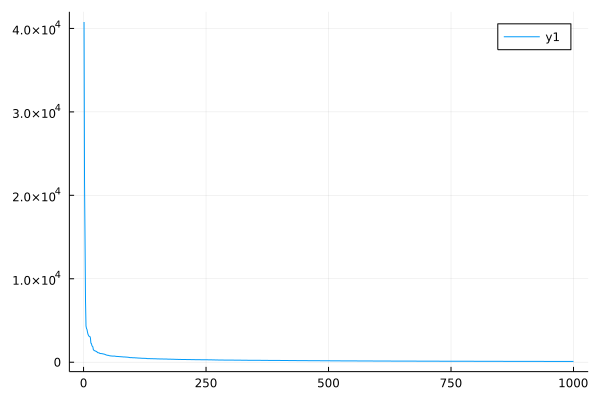

In [9]:
using Plots
plot(view(L, 1:1000))

## Partición de los datos para el experimento
Solo se guardarán las 100 listas de posteo más pobladas, con la idea de ser utilizados para caracterizar los algoritmos. Es importante hacer notar que dado el procedimiento, las listas de posteo son generadas a través de un procedimiento real.

In [10]:
function id2token(tok)
    M = Dict{Int,String}()
    for (k, v) in I.index.map
        M[v] = decode(tok, k)
    end
    
    M
end


open("listas-posteo-100.json", "w") do f
    P = partialsortperm(I.index.lists, 1:100, by=length, rev=true)
    M = id2token(TOK)
    
    for i in P
        plist = I.index.lists[i]
        token = M[i]
        list = first.(plist)
        print(token => length(list), " ")
        println(f, JSON.json((token, list)))
    end
end

#=I.index.lists
I.index.map=#

"_url" => 40773 "amlo" => 21628 "@lopezobrador" => 14682 "0" => 7345 "presidente" => 4341 "mexico" => 4040 "#elecciones0" => 3930 "pena" => 3616 "#amlo" => 3363 "|" => 3227 "gobierno" => 3119 "@epn" => 3096 "reunion" => 3076 "nieto" => 2910 "lopez" => 2285 "obrador" => 2235 "triunfo" => 2000 "trump" => 1894 "nacional" => 1843 "#mexico" => 1496 "electo" => 1444 "_ _url" => 1387 "@inemexico" => 1372 "pompeo" => 1342 "manuel" => 1316 "equipo" => 1296 "transicion" => 1279 "andres" => 1179 "seguridad" => 1143 "gabinete" => 1130 "palacio" => 1127 "➡" => 1116 "morena" => 1056 "estado" => 1044 "presidencial" => 1036 "encuentro" => 1033 "#transicion0" => 1027 "eleccion" => 1023 "va" => 1004 "virtual" => 987 "empresarios" => 987 "anos" => 962 "#envivo" => 956 "elecciones" => 924 "campana" => 904 "votos" => 867 "@ricardoanayac" => 859 "electoral" => 844 "video" => 828 "victoria" => 825 "_ y" => 820 "dijo" => 792 "durante" => 772 "hoy" => 769 "plan" => 757 "secretario" => 747 "proximo" => 746 "👉" 